### Imports

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from model import UNet
from utils import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
)
import cv2
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

### Configuration

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 16
PIN_MEMORY = True
NUM_WORKERS = 4
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_DIR = "/home/kpatel2s/work/kpatel2s_datasets/CamVid"

### Dataset

In [3]:
# Count the number of files in each folder
def count_files(path):
    return len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])

# Get the list of files in each folder
def get_files(path):
    # Only get folders not files
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]


folders = get_files(DATASET_DIR)

# sort the folders
folders.sort()

# Get the number of files in each folder
for folder in folders:
    print(f"{folder}: {count_files(DATASET_DIR + '/' + folder)}")

test: 232
test_labels: 232
train: 369
train_labels: 369
val: 100
val_labels: 100


In [4]:
# Get the class label csv file
classes = pd.read_csv(DATASET_DIR + '/class_dict.csv', index_col=0)

# There are total 32 classes
n_classes = len(classes)
print(f"Number of classes: {n_classes}")

print(classes) # Print the classes

Number of classes: 32
                     r    g    b
name                            
Animal              64  128   64
Archway            192    0  128
Bicyclist            0  128  192
Bridge               0  128   64
Building           128    0    0
Car                 64    0  128
CartLuggagePram     64    0  192
Child              192  128   64
Column_Pole        192  192  128
Fence               64   64  128
LaneMkgsDriv       128    0  192
LaneMkgsNonDriv    192    0   64
Misc_Text          128  128   64
MotorcycleScooter  192    0  192
OtherMoving        128   64   64
ParkingBlock        64  192  128
Pedestrian          64   64    0
Road               128   64  128
RoadShoulder       128  128  192
Sidewalk             0    0  192
SignSymbol         192  128  128
Sky                128  128  128
SUVPickupTruck      64  128  192
TrafficCone          0    0   64
TrafficLight         0   64   64
Train              192   64  128
Tree               128  128    0
Truck_Bus          19

In [5]:
# Create a dictionary mapping for the classes with their colors

cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
cls2rgb

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'SUVPickupTruck': [64, 128, 192],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

In [6]:
# Explore the dataset
# Visualize some samples

train_img_loc = sorted(np.array(glob(DATASET_DIR + '/train/*')))
train_mask_loc = sorted(np.array(glob(DATASET_DIR + '/train_labels/*')))

Image shape: (720, 960, 3), Mask shape: (720, 960, 3)


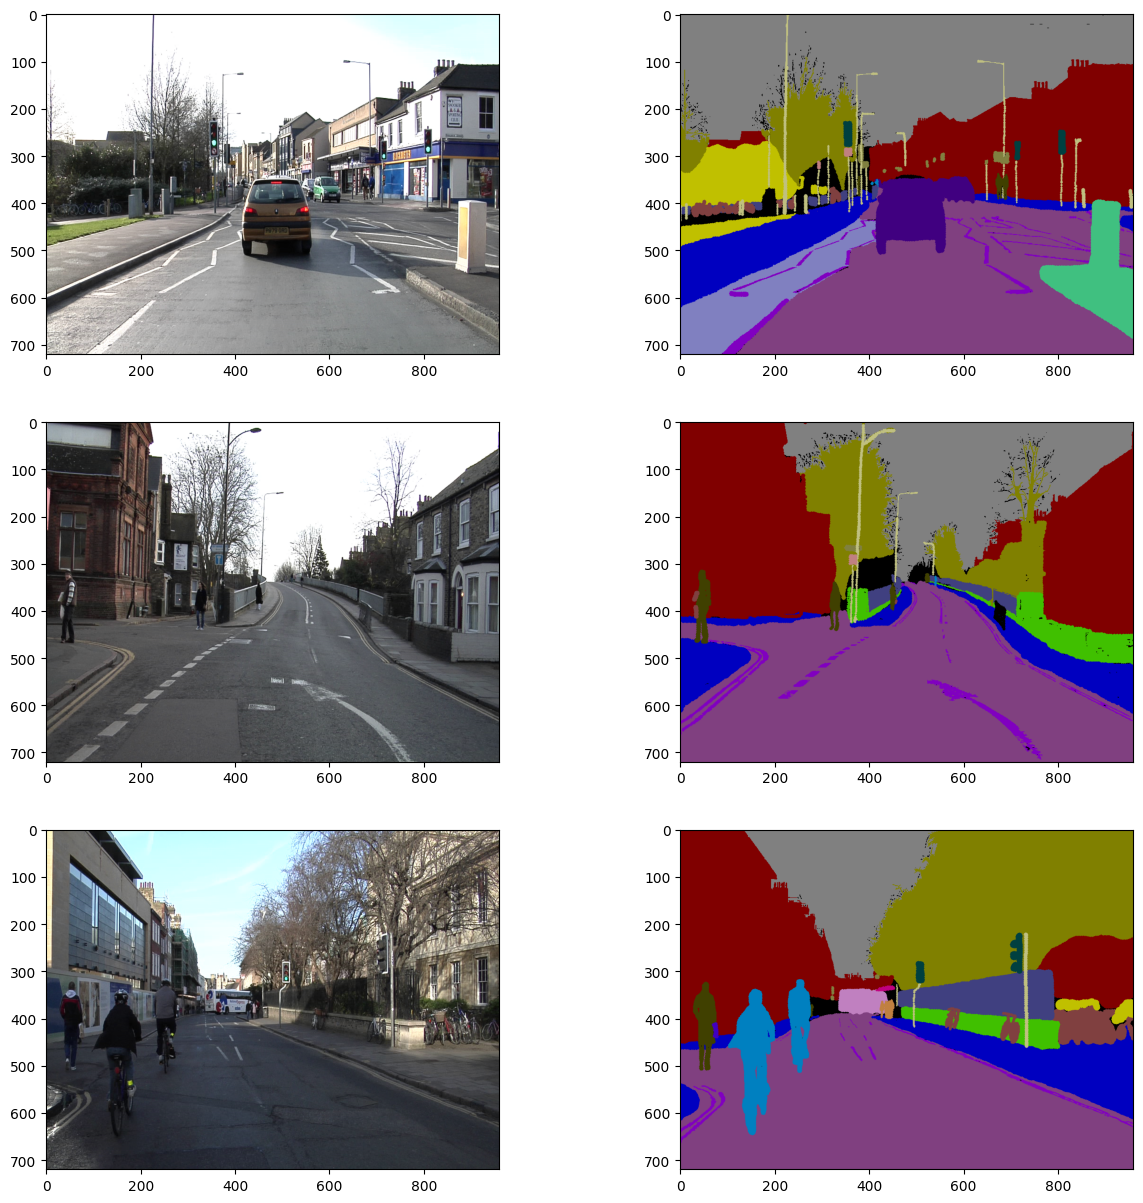

In [7]:
# Combine the images and masks side by side give 3 pairs in rows
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

random_idx = np.random.choice(len(train_img_loc), size=3, replace=False)

for i in range(3):
    img = cv2.imread(train_img_loc[random_idx[i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(train_mask_loc[random_idx[i]])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(mask)

# Shape of the image and mask
print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")

### Adjust Mask

In [8]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for color in list(cls2rgb.values()):
        equality = np.equal(mask, color) # Check if the mask is equal to the color, return True or False, same shape as mask
        class_map = np.all(equality, axis=-1) # Check if all the values in the array are True, shape WxH (no channels)
        semantic_map.append(class_map) # Append the class map

    semantic_map = np.stack(semantic_map, axis=-1).astype(np.uint8) # Shape WxHx32

    if flat:
        semantic_map = np.reshape(semantic_map, (-1, 256*256))

    return np.float32(semantic_map)

In [9]:
new_mask = adjust_mask(mask)
print(f"New mask shape: {new_mask.shape}")

New mask shape: (720, 960, 32)


In [10]:
# Index to RGB

idx2rgb = {idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
idx2rgb

{0: array([ 64, 128,  64]),
 1: array([192,   0, 128]),
 2: array([  0, 128, 192]),
 3: array([  0, 128,  64]),
 4: array([128,   0,   0]),
 5: array([ 64,   0, 128]),
 6: array([ 64,   0, 192]),
 7: array([192, 128,  64]),
 8: array([192, 192, 128]),
 9: array([ 64,  64, 128]),
 10: array([128,   0, 192]),
 11: array([192,   0,  64]),
 12: array([128, 128,  64]),
 13: array([192,   0, 192]),
 14: array([128,  64,  64]),
 15: array([ 64, 192, 128]),
 16: array([64, 64,  0]),
 17: array([128,  64, 128]),
 18: array([128, 128, 192]),
 19: array([  0,   0, 192]),
 20: array([192, 128, 128]),
 21: array([128, 128, 128]),
 22: array([ 64, 128, 192]),
 23: array([ 0,  0, 64]),
 24: array([ 0, 64, 64]),
 25: array([192,  64, 128]),
 26: array([128, 128,   0]),
 27: array([192, 128, 192]),
 28: array([64,  0, 64]),
 29: array([192, 192,   0]),
 30: array([0, 0, 0]),
 31: array([ 64, 192,   0])}

In [11]:
# Map the idx to RGB

def map_class_to_rgb(p):
    return idx2rgb[p[0]]

def convert_mask_to_rgb(new_mask):
    # Get the index of the maximum value along the last axis
    mask_indices = np.argmax(new_mask, axis=-1)

    # Expand the dimensions of the array
    expanded_indices = np.expand_dims(mask_indices, axis=-1)

    # Apply the function `map_class_to_rgb` to each 1-D slice along the last axis
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, expanded_indices)

    return rgb_mask

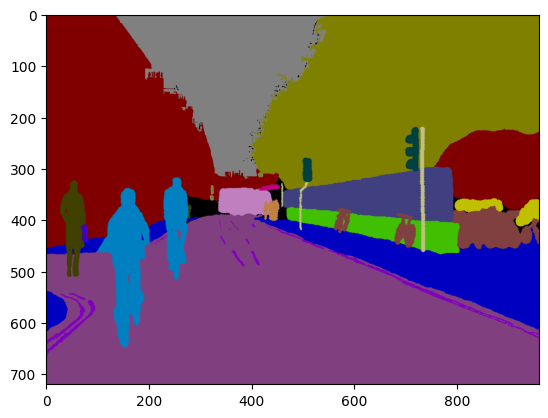

In [12]:
rgb_mask = convert_mask_to_rgb(new_mask)
plt.imshow(rgb_mask)

### Dataloader

In [13]:
class CamVidDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.image_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(self.image_dir)
        # self.indices = indices if indices is not None else range(
        #     len(self.image_dir))
        # self.images = [self.all_images[i] for i in self.indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index].replace('.png', '_L.png'))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = adjust_mask(mask)

        if self.transform is not None:
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation["image"]
            mask = augmentation["mask"]

        # Convert one-hot encoded mask to ckass indices
        if mask.shape[-1] == 3 or mask.shape[-1] == 32:
            mask = torch.argmax(mask, dim=-1)
            
        return image, mask

In [14]:
def get_loaders(
    dataset_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_dataset = CamVidDataset(
        img_dir=dataset_dir + "/train",
        mask_dir=dataset_dir + "/train_labels",
        transform=train_transform
    )

    val_dataset = CamVidDataset(
        img_dir=dataset_dir + "/val",
        mask_dir=dataset_dir + "/val_labels",
        transform=val_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [15]:
# Transforms
train_transforms = A.Compose(
    [
        A.Resize(height=IMG_SIZE, width=IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMG_SIZE, width=IMG_SIZE),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [16]:
train_loader, val_loader = get_loaders(
    dataset_dir=DATASET_DIR,
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=val_transforms,
    pin_memory=PIN_MEMORY,
    num_workers=NUM_WORKERS
)

In [17]:
img, mask = train_loader.dataset[0]
img.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

In [18]:
def mask_cls_to_rgb(mask):
    # Expand the dimensions of the array
    expanded_indices = np.expand_dims(mask, axis=-1)

    # Apply the function `map_class_to_rgb` to each 1-D slice along the last axis
    rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, expanded_indices)

    return rgb_mask

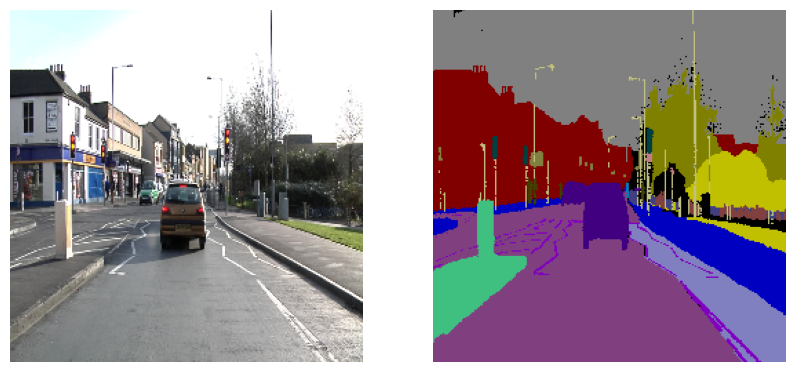

In [19]:
# Visualize the image and mask
def visualize(image, mask):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.axis("off")

visualize(img.permute(1, 2, 0), mask_cls_to_rgb(mask))

### UNet Model

In [20]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)
        # NOTE: Tip of the day
        # Always use separate instances of BatchNorm for different inputs to maintain correct normalization statistics.
        # This ensures each layer handles its own data distribution independently.
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1)

    def forward(self, x):
        # TODO: replace with single line return
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

# LEARNING FROM HERE
'''
torch.rand vs torch.randn

- torch.rand: generates random numbers between [0, 1) with uniform distribution
- torch.randn: generates numbers with normal distribution with mean = 0 and std = 1
(both takes shape as input)
'''

class Encoder(nn.Module):
    def __init__(self, channels=(1, 64, 128, 256)):
        super().__init__()
        self.encoder_block = nn.ModuleList(
            [Block(in_channels=channels[i], out_channels=channels[i + 1])
             for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        skip_connections = []

        for block in self.encoder_block:
            x = block(x)
            skip_connections.append(x)
            x = self.pool(x)

        # print(f'Shape of x after encoder: {x.shape}')

        return skip_connections

class Decoder(nn.Module):
    def __init__(self, channels=(512, 256, 128, 64)):
        super().__init__()
        self.channels = channels
        self.decoder_block = nn.ModuleList(
            [Block(in_channels=channels[i], out_channels=channels[i + 1])
             for i in range(len(channels) - 1)]
        )
        self.upconv = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
             for i in range(len(channels) - 1)]
        )

    def forward(self, x, skip_connections):
        for i in range(len(self.channels) - 1):
            x = self.upconv[i](x)
            skip_connection = skip_connections.pop()
            # dim = 1 is the channel dimension
            x = torch.cat([x, skip_connection], dim=1)
            x = self.decoder_block[i](x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=(64, 128, 256, 512)):
        super().__init__()
        self.encoder = Encoder(channels=(in_channels,) + features[:-1])

        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            Block(features[-2], features[-1]),
        )

        self.decoder = Decoder(channels=features[::-1])
        self.head = nn.Conv2d(in_channels=features[0],
                              out_channels=out_channels,
                              kernel_size=1)

    def forward(self, x):
        skip_connections = self.encoder(x)
        x = self.bottleneck(skip_connections[-1])
        x = self.decoder(x, skip_connections)
        x = self.head(x)
        # NOTE: keeping it as raw logits only. BCELogitsLoss would take care of it.
        # Keep in mind that while inference, we need to apply sigmoid on output.
        return x

In [21]:
# Check UNet
unet_model = UNet(in_channels=3, out_channels=n_classes)
x = torch.randn(1, 3, 512, 512)
out = unet_model(x)
print(f'\nShape of input: {x.shape}')
print(f'Shape of UNet out: {out.shape}')


Shape of input: torch.Size([1, 3, 512, 512])
Shape of UNet out: torch.Size([1, 32, 512, 512])


### Configurations

In [22]:
model = UNet(in_channels=3, out_channels=n_classes).to(DEVICE)
# Also try, focal loss here
loss_fn = nn.CrossEntropyLoss()  # for multi class, use cross entropy
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [23]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loss_loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loss_loop):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loss_loop.set_postfix(loss=loss.item())

In [24]:
scaler = torch.cuda.amp.GradScaler() # for Automatic Mixed Precision (AMP) training

for epoch in range(NUM_EPOCHS):
    break
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    # save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    # save_predictions_as_imgs(
    #     val_loader, model, folder="saved_images/", device=DEVICE)

100%|██████████| 24/24 [01:32<00:00,  3.84s/it, loss=2.57]


Pixel Accuracy: 0.31889480352401733
Dice Score: 0.18995040655136108
IoU Score: 0.18088019958564214


100%|██████████| 24/24 [01:35<00:00,  3.96s/it, loss=2.09]


Pixel Accuracy: 0.5805310010910034
Dice Score: 0.12664352357387543
IoU Score: 0.10702438226767949


100%|██████████| 24/24 [01:40<00:00,  4.17s/it, loss=1.9] 


Pixel Accuracy: 0.7187178730964661
Dice Score: 0.16592717170715332
IoU Score: 0.14318807742425374


100%|██████████| 24/24 [01:34<00:00,  3.95s/it, loss=1.88]


Pixel Accuracy: 0.7250115871429443
Dice Score: 0.21519307792186737
IoU Score: 0.19468033526624953


100%|██████████| 24/24 [01:33<00:00,  3.91s/it, loss=1.54]


Pixel Accuracy: 0.751228392124176
Dice Score: 0.23320668935775757
IoU Score: 0.21103880660874502
